In [1]:
# Automatically reload modules after executing each cell.
%load_ext autoreload
%autoreload 2

In [2]:
# General imports
import numpy as np
import os

# Plotting
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from matplotlib import rc
import matplotlib.font_manager
rc('font', family='serif')
rc('text', usetex=True)
rc('font', size=22)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

# ML imports
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras
import tensorflow.keras.backend as K
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping

np.random.seed(666) # Need to do more to ensure data is the same across runs.

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # pick a number < 4 on ML4HEP; < 3 on Voltan 
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

2022-04-17 15:46:59.217131: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-04-17 15:46:59.242394: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: Quadro RTX 6000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2022-04-17 15:46:59.242553: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-04-17 15:46:59.244029: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-04-17 15:46:59.245748: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-04-17 15:46:59.245966: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2

In [4]:
### Generate the data.
N = 10**6
r = 5
sigma = 1

# Background is Gamma(r, √(σ/r)). Signal is Gamma(r + 1, √(σ/(r + 1))))
bkgd = np.random.gamma(r, (sigma / r)**0.5, N)
sgnl = np.random.gamma(r + 1, (sigma / (r + 1))**0.5, N)
X = np.concatenate([bkgd, sgnl])
y = np.concatenate([np.zeros(N), np.ones(N)])

X_train, X_test, y_train, y_test = train_test_split(X, y)


N = 10**6
mu = 0.1
sigma = 1

# Background is Normal(-μ, σ). Signal is Normal(μ, σ))
bkgd = np.random.normal(-mu, sigma, N)
sgnl = np.random.normal(mu, sigma, N)
X = np.concatenate([bkgd, sgnl])
y = np.concatenate([np.zeros(N), np.ones(N)])

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [5]:
# Loss functions
def bce(y_true, y_pred):
    # Clipping to (ɛ, 1 - ɛ) is fine since the final activation is sigmoid.
    y_pred = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())
    
    return -((y_true) * K.log(y_pred + K.epsilon()) + 
             (1. - y_true) * K.log(1. - y_pred))

def square_bce(y_true, y_pred):
    return -((y_true) * K.log(y_pred**2) + 
             (1. - y_true) * K.log(1. - y_pred**2))

def exp_bce(y_true, y_pred):
    return -((y_true) * (y_pred) + 
             (1. - y_true) * (1. - y_pred))

def mse(y_true, y_pred):
    # Clipping to (ɛ, 1 - ɛ) is fine since the final activation is sigmoid.
    y_pred = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())
    
    return -((y_true) * -K.square(1. - y_pred) + 
             (1. - y_true) * -K.square(y_pred))

def square_mse(y_true, y_pred):
    return -((y_true) * -K.square(1. - y_pred) 
             + (1. - y_true) * -K.square(y_pred + K.epsilon()))

def exp_mse(y_true, y_pred):
    return -((y_true) * -K.square(1. - K.exp(y_pred)) + 
             (1. - y_true) * -K.square(K.exp(y_pred))) 

def get_mse(p):
    def mse_p(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())
    
        return -((y_true) * -K.pow(1. - y_pred, p) + 
                 (1. - y_true) * -K.pow(y_pred, p))
    return mse_p
             
def mlc(y_true, y_pred):
    return -((y_true) * K.log(y_pred + K.epsilon()) + 
             (1. - y_true) * (1. - y_pred))

def square_mlc(y_true, y_pred):
    return -((y_true) * K.log(y_pred**2 + K.epsilon()) + 
             (1. - y_true) * (1. - y_pred**2))

def exp_mlc(y_true, y_pred):
    return -((y_true) * (y_pred) + 
             (1. - y_true) * (1. - K.exp(y_pred)))

def sqr(y_true, y_pred):
    return -((y_true) * -1. / K.sqrt(y_pred + K.epsilon()) + 
             (1. - y_true) * -K.sqrt(y_pred + K.epsilon()))

def square_sqr(y_true, y_pred):
    return -((y_true) * -1. / K.sqrt(K.square(y_pred)) + 
             (1. - y_true) * -K.sqrt(K.square(y_pred)))

def exp_sqr(y_true, y_pred):
    return -((y_true) * -1. / K.sqrt(K.exp(y_pred)) + 
             (1. - y_true) * -K.sqrt(K.exp(y_pred)))

def get_sqr(p):
    def sqr_p(y_true, y_pred):
        return -((y_true) * -K.pow(y_pred + K.epsilon(), -p/2) + 
                 (1. - y_true) * -K.pow(y_pred + K.epsilon(), p/2))
    return sqr_p

def get_exp_sqr(p):
    def exp_sqr_p(y_true, y_pred):
        return -((y_true) * -K.pow(K.exp(y_pred), -p/2) + 
                 (1. - y_true) * -K.pow(K.exp(y_pred), p/2))
    return exp_sqr_p
        
# Likelihood ratios
def lr(x):
    #return np.exp(-10 + 11) * (10/11)**x
    #return np.exp(-(1/(2 * sigma**2)) * ( (x - mu)**2 - (x + mu)**2))
    r_1 = r
    r_2 = r + 1
    v_1 = lam
    v_2 = lam
    return v_2**r_2 * np.math.factorial(r_1 - 1) * x**(r_2 - r_1) * \
           np.exp(-(v_2 - v_1)*x) / (v_1**r_1 * np.math.factorial(r_2 - 1))

def odds_lr(model):
    def model_lr(x):
        f = model.predict(x)
        return np.squeeze(f / (1. - f))
    return model_lr

def square_odds_lr(model):
    def model_lr(x):
        f = model.predict(x)
        return np.squeeze(f**2 / (1. - f**2))
    return model_lr

def exp_odds_lr(model):
    def model_lr(x):
        f = model.predict(x)
        return np.squeeze(np.exp(f) / (1. - np.exp(f)))
    return model_lr

def pure_lr(model):
    def model_lr(x):
        f = model.predict(x)
        return np.squeeze(f)
    return model_lr

def square_lr(model):
    def model_lr(x):
        f = model.predict(x)
        return np.squeeze(f**2)
    return model_lr

def exp_lr(model):
    def model_lr(x):
        f = model.predict(x)
        return np.squeeze(np.exp(f))
    return model_lr

def pow_lr(model, p):
    def model_lr(x):
        f = model.predict(x)
        return np.squeeze(f**p)
    return model_lr

def exp_pow_lr(model, p):
    def model_lr(x):
        f = model.predict(x)
        return np.squeeze(np.exp(f)**p)
    return model_lr

def pow_odds_lr(model, p):
    def model_lr(x):
        f = model.predict(x)
        return np.squeeze( (f / (1. - f))**(p - 1))
    return model_lr

def make_mae(mu_mae, sigma_mae, N_mae=10**4):
    bkgd_mae = np.random.normal(-mu_mae, sigma_mae, N_mae)
    sgnl_mae = np.random.normal(mu_mae, sigma_mae, N_mae)
    X_mae = np.concatenate([bkgd_mae, sgnl_mae])
    
    def mae(model_lr):
        nonlocal X_mae
        return np.abs(model_lr(X_mae) - lr(X_mae)).mean()
    return mae

def make_mae(r_mae, sigma_mae, N_mae=10**4):
    bkgd_mae = np.random.gamma(r_mae, (sigma_mae / r_mae)**0.5, N_mae)
    sgnl_mae = np.random.gamma(r_mae + 1, (sigma_mae / (r_mae + 1))**0.5, N_mae)
    X_mae = np.concatenate([bkgd_mae, sgnl_mae])
    
    def mae(model_lr):
        nonlocal X_mae
        return np.abs(model_lr(X_mae) - lr(X_mae)).mean()
    return mae

def make_mpe(mu_mpe, sigma_mpe, N_mpe=10**4):
    bkgd_mpe = np.random.normal(-mu_mpe, sigma_mpe, N_mpe)
    sgnl_mpe = np.random.normal(mu_mpe, sigma_mpe, N_mpe)
    X_mpe = np.concatenate([bkgd_mpe, sgnl_mpe])
    
    def mpe(model_lr):
        nonlocal X_mpe
        return np.abs((model_lr(X_mpe) - lr(X_mpe)) / lr(X_mpe)).mean() * 100
    return mpe
    
mae = make_mae(r, sigma)

In [6]:
earlystopping = EarlyStopping(patience=10,
                              verbose=0,
                              restore_best_weights=True)

In [7]:
# Models
def create_model(loss,
                 hidden='relu', 
                 output='sigmoid', 
                 dropout=True, 
                 optimizer='adam', 
                 metrics=['accuracy'], 
                 verbose=0):
    model = Sequential()
    if dropout:
        model.add(Dense(64, activation=hidden, input_shape=(1, )))
        model.add(Dropout(0.1))
        model.add(Dense(128, activation=hidden))
        model.add(Dropout(0.1))
        model.add(Dense(64, activation=hidden))
        model.add(Dropout(0.1))
        model.add(Dense(1, activation=output))
    else: 
        model.add(Dense(64, activation=hidden, input_shape=(1, )))
        model.add(Dense(128, activation=hidden))
        model.add(Dense(64, activation=hidden))
        model.add(Dense(1, activation=output))        
    
    return model

def train(loss,
          hidden='relu', 
          output='sigmoid', 
          dropout=True, 
          optimizer='adam', 
          metrics=['accuracy'], 
          verbose=0):
    model = create_model(loss, hidden, output, dropout, optimizer, metrics, verbose)      
    
    model.compile(loss=loss,
                  optimizer=optimizer, 
                  metrics=metrics)
    
    trace = model.fit(X_train, 
                      y_train,
                      epochs = 100, 
                      batch_size=int(0.1*N), 
                      validation_data=(X_test, y_test),
                      callbacks=[earlystopping], 
                      verbose=verbose)
    print(trace.history['val_loss'][-1], end = ' ')
    
    return model

In [8]:
# Plotting functions
def get_preds(model_lrs, xs=np.linspace(4, 16, 1000)):
    # Takes in model_lrs, a list of model likelihood ratios and xs, a list of 
    # values on which to compute the likelihood ratios. Returns a 2D array. The 
    # nth row is the likelihood ratio predictions from the nth model in 
    # model_lrs.
    return np.array([model_lr(xs) for model_lr in model_lrs])
    
def avg_lr(preds):
    # Takes in a 2D array of multiple models' likelihood ratio predictions. 
    # Returns the average likelihood ratio prediction and its error.
    return preds.mean(axis=0), preds.std(axis=0)

def avg_lrr(preds, xs=np.linspace(4, 16, 1000)):
    # Takes in a 2D array of multiple models' likelihood ratio predictions. 
    # Returns the average ratio of predicted likelihood to true likelihood and 
    # its error.
    lrr_preds = preds / lr(xs)
    return lrr_preds.mean(axis=0), lrr_preds.std(axis=0)
    
def lr_plot(ensembles,
            title=None,
            filename=None,
            cs = ['brown', 'green', 'red', 'blue'],
            lss = ['-', '--', '-.', ':'],
            xs=np.linspace(0, 20, 1000)):
            #xs=np.linspace(4, 16, 1000)):
            #xs=np.linspace(-6, 6, 1000)):
    # Takes in a list of pairs (lr_avg, lr_err). Plots them against the true 
    # likelihood.
    fig, ax_1 = plt.subplots(figsize = (10, 6))
    
    # Plot true likelihood
    plt.plot(xs, lr(xs), label = 'Exact', c='k', ls='-')
    
    # Plot model likelihoods
    for i in range(len(ensembles)):
        avg, err, lbl = ensembles[i]
        plt.plot(xs, avg, label=lbl, c=cs[i], ls=lss[i])
        #plt.fill_between(xs, avg - err, avg + err, color=cs[i], alpha=0.1)
    plt.legend()
    ax_1.minorticks_on()
    ax_1.tick_params(direction='in', which='both',length=5)
    plt.ylabel('Likelihood Ratio')

    # Plot background and signal
    ax_2 = ax_1.twinx()
    #bins = np.linspace(4, 16, 100)
    bins = np.linspace(0, 20, 100)
    #bins = np.linspace(-6, 6, 100)
    plt.hist(sgnl, alpha=0.1, bins=bins)
    plt.hist(bkgd, alpha=0.1, bins=bins)
    ax_2.minorticks_on()
    ax_2.tick_params(direction='in', which='both',length=5)
    plt.ylabel('Count')

    plt.xlim(xs[0], xs[-1])
    plt.xlabel(r'$x$')
    #plt.title(r"$\mu_{\rm{sgnl}}="+str(10.1)+r", \mu_{\rm{bkgd}}="+str(9.9)+r"$",loc="right",fontsize=20)
    plt.title(r"$r_{\rm{sgnl}}="+str(r)+r", r_{\rm{bkgd}}="+str(r+1)+r"$",loc="right",fontsize=20)
    #plt.title(r"$\mu_{\rm{sgnl}}="+str(mu)+r", \mu_{\rm{bkgd}}="+str(-mu)+r"$",loc="right",fontsize=20)
    if title != None:
        plt.title(title, loc="left", fontsize=20)
    if filename != None:
        plt.savefig(filename, dpi=1200, bbox_inches='tight')

def lrr_plot(ensembles,
             title=None,
             filename=None,
             cs = ['brown', 'green', 'red', 'blue'],
             lss = [':', '--', '-.', ':'],
             xs=np.linspace(0, 20, 1000)):
             #xs=np.linspace(4, 16, 1000)):
             #xs=np.linspace(-6, 6, 1000)):
    # Takes in a list of pairs (lrr_avg, lrr_err). Plots them.
    fig, ax_1 = plt.subplots(figsize = (10, 6))
    
    # Plot ratios of likelihood ratios
    for i in range(len(ensembles)):
        avg, err, lbl = ensembles[i]
        plt.plot(xs, avg, label=lbl, c=cs[i], ls=lss[i])
        #plt.fill_between(xs, avg - err, avg + err, color=cs[i], alpha=0.1)
    plt.axhline(1,ls=":",color="grey", lw=0.5)
    plt.axvline(0,ls=":",color="grey", lw=0.5)
    plt.legend()
    ax_1.minorticks_on()
    ax_1.tick_params(direction='in', which='both',length=5)
    plt.ylim(0.94, 1.06)
    plt.ylabel('Ratio')

    # Plot background and signal
    ax_2 = ax_1.twinx()
    #bins = np.linspace(4, 16, 100)
    bins = np.linspace(0, 20, 100)
    #bins = np.linspace(-6, 6, 100)
    plt.hist(sgnl, alpha=0.1, bins=bins)
    plt.hist(bkgd, alpha=0.1, bins=bins)
    ax_2.minorticks_on()
    ax_2.tick_params(direction='in', which='both',length=5)
    plt.ylabel('Count')

    plt.xlim(xs[0], xs[-1])
    plt.xlabel(r'$x$')
    #plt.title(r"$\mu_{\rm{sgnl}}="+str(10.1)+r", \mu_{\rm{bkgd}}="+str(9.9)+r"$",loc="right",fontsize=20)
    plt.title(r"$r_{\rm{sgnl}}="+str(r)+r", r_{\rm{bkgd}}="+str(r+1)+r"$",loc="right",fontsize=20)
    #plt.title(r"$\mu_{\rm{sgnl}}="+str(mu)+r", \mu_{\rm{bkgd}}="+str(-mu)+r"$",loc="right",fontsize=20)
    if title != None:
        plt.title(title, loc="left", fontsize=20)
    if filename != None:
        plt.savefig(filename, dpi=1200, bbox_inches='tight')

In [ ]:
1/0

# BCE $C$ Parametrizations

In [ ]:
num = 1
reps = 10

# Model parameters
params_1 = {'loss':bce}
params_2 = {'loss':square_bce, 'output':'linear'}
params_3 = {'loss':exp_bce, 'output':'linear'}

filestr_1 = 'models/bce_c_param/set_' + str(num) + '/linear/model_{}.h5'
filestr_2 = 'models/bce_c_param/set_' + str(num) + '/square/model_{}.h5'
filestr_3 = 'models/bce_c_param/set_' + str(num) + '/exp/model_{}.h5'

In [ ]:
%%time
# Train and save models

for i in range(reps):
    print(i, end = ' ')
    model_1 = train(**params_1)
    model_2 = train(**params_2)
    model_3 = train(**params_3)
    print()
    model_1.save_weights(filestr_1.format(i))
    model_2.save_weights(filestr_2.format(i))
    model_3.save_weights(filestr_3.format(i))

In [ ]:
# Get model likelihood ratios.
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps
for i in range(reps):
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = odds_lr(model_1)
    lrs_2[i] = square_odds_lr(model_2)
    lrs_3[i] = exp_odds_lr(model_3)

In [ ]:
# Get average predictions and errors. Add on the labels for plotting.
lr_1 = avg_lr(get_preds(lrs_1)) + ('BCE (linear)',)
lr_2 = avg_lr(get_preds(lrs_2)) + ('BCE (square)',)
lr_3 = avg_lr(get_preds(lrs_3)) + ('BCE (exponential)',)

lrr_1 = avg_lrr(get_preds(lrs_1)) + ('BCE (linear)',)
lrr_2 = avg_lrr(get_preds(lrs_2)) + ('BCE (square)',)
lrr_3 = avg_lrr(get_preds(lrs_3)) + ('BCE (exponential)',)

In [ ]:
lr_plot([lr_1, lr_2, lr_3], 
        r'BCE $C$ Parametrizations',
        filename='plots/bce_c_param/set_{}/lrs.png'.format(num))

In [ ]:
lrr_plot([lrr_1, lrr_2, lrr_3], 
         r'BCE $C$ Parametrizations',
         filename='plots/bce_c_param/set_{}/lrrs.png'.format(num))

# MSE $C$ Parametrizations

In [ ]:
num = 1
reps = 10

# Model parameters
params_1 = {'loss':mse}
params_2 = {'loss':square_mse, 'output':'linear'}
params_3 = {'loss':exp_mse, 'output':'linear'}

filestr_1 = 'models/mse_c_param/set_' + str(num) + '/linear/model_{}.h5'
filestr_2 = 'models/mse_c_param/set_' + str(num) + '/square/model_{}.h5'
filestr_3 = 'models/mse_c_param/set_' + str(num) + '/exp/model_{}.h5'

In [ ]:
%%time
# Train and save models

for i in range(reps):
    print(i, end = ' ')
    model_1 = train(**params_1)
    model_2 = train(**params_2)
    model_3 = train(**params_3)
    print()
    model_1.save_weights(filestr_1.format(i))
    model_2.save_weights(filestr_2.format(i))
    model_3.save_weights(filestr_3.format(i))

In [ ]:
# Get model likelihood ratios.
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps
for i in range(reps):
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = odds_lr(model_1)
    lrs_2[i] = square_odds_lr(model_2)
    lrs_3[i] = exp_odds_lr(model_3)

In [ ]:
# Get average predictions and errors. Add on the labels for plotting.
lr_1 = avg_lr(get_preds(lrs_1)) + ('MSE (linear)',)
lr_2 = avg_lr(get_preds(lrs_2)) + ('MSE (square)',)
lr_3 = avg_lr(get_preds(lrs_3)) + ('MSE (exponential)',)

lrr_1 = avg_lrr(get_preds(lrs_1)) + ('MSE (linear)',)
lrr_2 = avg_lrr(get_preds(lrs_2)) + ('MSE (square)',)
lrr_3 = avg_lrr(get_preds(lrs_3)) + ('MSE (exponential)',)

In [ ]:
lr_plot([lr_1, lr_2, lr_3], 
        r'MSE $C$ Parametrizations',
        filename='plots/mse_c_param/set_{}/lrs.png'.format(num))

In [ ]:
lrr_plot([lrr_1, lrr_2, lrr_3], 
         r'MSE $C$ Parametrizations',
         filename='plots/mse_c_param/set_{}/lrrs.png'.format(num))

# MSE $A/B$ Parametrization

In [ ]:
num = 0
reps = 20

ps = np.round(np.linspace(-4, 4, 161), 2)
filestr = 'models/mse_ab_param/set_' + str(num) + '/model_{}_{}.h5'

In [ ]:
# Train models
for p in ps:
    print('===================================================\n{}'.format(p))
    params = {'loss': get_mse(p)}
    for i in range(reps):
        print(i, end = ' ')
        model = train(**params)
        print()
        model.save_weights(filestr.format(p, i))

In [ ]:
# Get model likelihood ratios.
lrs = {}
for p in ps:
    print(p)
    lrs[p] = [None] * reps
    params = {'loss': get_mse(p)}
    for i in range(reps):
        model = create_model(**params)
        model.load_weights(filestr.format(p, i))
        lrs[p][i] = pow_odds_lr(model, p) #### FIX THIS
        print(i, end = ' ')
    print()

In [ ]:
mae_avg = []
mae_err = []

for p in ps:
    maes = [mae(lr) for lr in lrs[p]]
    mae_avg += [np.mean(maes)]
    mae_err += [np.std(maes)]
    print(p, '\t', mae_avg[-1])

In [ ]:
mae_avg = np.array(mae_avg)
mae_err = np.array(mae_err)

In [ ]:
fig, ax = plt.subplots(figsize = (10, 6))

plt.plot(ps, mae_avg, c='blue')

plt.minorticks_on()
plt.tick_params(direction='in', which='both',length=5)
plt.ylim(0, 0.5)

plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$p$')

plt.title(r"$\mu_{\rm{sgnl}}="+str(mu)+r", \mu_{\rm{bkgd}}="+str(-mu)+r"$",
          loc="right",
          fontsize=20);
plt.title(r"MSE $A/B$ Parametrization",loc="left",fontsize=20);
plt.savefig('plots/mse_ab_param/set_{}/maes.png'.format(num), 
            dpi=1200, 
            bbox_inches='tight')

# MLC $C$ Parametrizations

In [9]:
### Generate the data.
N = 10**6
r = 5
lam = 1

# Background is Gamma(r, λ). Signal is Gamma(r + 1, λ)
bkgd = np.random.gamma(r, lam, N)
sgnl = np.random.gamma(r + 1, lam, N)
D = np.concatenate([bkgd, sgnl])
X = (D - np.mean(D)) / np.std(D)
y = np.concatenate([np.zeros(N), np.ones(N)])

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [10]:
def lr(x):
    #return np.exp(-10 + 11) * (10/11)**x
    #return np.exp(-(1/(2 * sigma**2)) * ( (x - mu)**2 - (x + mu)**2))
    r_1 = r
    r_2 = r + 1
    v_1 = lam
    v_2 = lam
    return v_2**r_2 * np.math.factorial(r_1 - 1) * x**(r_2 - r_1) * \
           np.exp(-(v_2 - v_1)*x) / (v_1**r_1 * np.math.factorial(r_2 - 1))

In [11]:
num = 4
reps = 100

# Model parameters
params_1 = {'loss':mlc, 'output':'relu'}
params_2 = {'loss':square_mlc, 'output':'linear'}
params_3 = {'loss':exp_mlc, 'output':'linear'}

filestr_1 = 'models/mlc_c_param/set_' + str(num) + '/linear/model_{}.h5'
filestr_2 = 'models/mlc_c_param/set_' + str(num) + '/square/model_{}.h5'
filestr_3 = 'models/mlc_c_param/set_' + str(num) + '/exp/model_{}.h5'

In [12]:
%%time
# Train and save models

for i in range(reps):
    print(i, end = ' ')
    model_1 = train(**params_1)
    model_2 = train(**params_2)
    model_3 = train(**params_3)
    print()
    model_1.save_weights(filestr_1.format(i))
    model_2.save_weights(filestr_2.format(i))
    model_3.save_weights(filestr_3.format(i))

0 

2022-04-17 15:47:21.200291: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2022-04-17 15:47:21.208990: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2994530000 Hz
2022-04-17 15:47:21.210117: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x558b24235490 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-04-17 15:47:21.210147: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-04-17 15:47:21.333185: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x558b251e17b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-04-17 15:47:21.333237: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Quadro RTX 6000, Compute Capability 7.5
2022-04-17 15:47:21.335251: I 

-0.04680175706744194 -0.04675278067588806 -0.04638775810599327 
1 -0.04685318470001221 -0.04659096896648407 -0.04666263237595558 
2 -0.04677107185125351 -0.04681411758065224 -0.04648976773023605 
3 -0.046866368502378464 -0.04681123420596123 -0.04671584069728851 
4 -0.04686513915657997 -0.04680750146508217 -0.04661259800195694 
5 -0.04675167798995972 -0.03712262585759163 -0.046616245061159134 
6 -0.046694837510585785 -0.04675549641251564 -0.04642155021429062 
7 -0.046844277530908585 -0.04111349210143089 -0.046763356775045395 
8 -0.046697184443473816 -0.04058683663606644 -0.04662664234638214 
9 -0.04679377004504204 -0.04660480469465256 -0.0463741309940815 
10 -0.04681353271007538 -0.04674500599503517 -0.04655264690518379 
11 -0.04680934548377991 -0.046446509659290314 -0.04640031233429909 
12 -0.046685654670000076 -0.046845439821481705 -0.04652510583400726 
13 -0.04667697474360466 -0.046873483806848526 -0.04674980044364929 
14 -0.046722717583179474 -0.04677416384220123 -0.0466204062104225

In [13]:
# Get model likelihood ratios.
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps
for i in range(reps):
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = pure_lr(model_1)
    lrs_2[i] = square_lr(model_2)
    lrs_3[i] = exp_lr(model_3)

In [14]:
# Get average predictions and errors. Add on the labels for plotting.
ds = np.linspace(0, 20, 1000)
xs = (ds - np.mean(D)) / np.std(D)

lr_1 = avg_lr(get_preds(lrs_1, xs)) + ('MLC (linear)',)
lr_2 = avg_lr(get_preds(lrs_2, xs)) + ('MLC (square)',)
lr_3 = avg_lr(get_preds(lrs_3, xs)) + ('MLC (exponential)',)

lrr_1 = avg_lrr(get_preds(lrs_1, xs), ds) + ('MLC (linear)',)
lrr_2 = avg_lrr(get_preds(lrs_2, xs), ds) + ('MLC (square)',)
lrr_3 = avg_lrr(get_preds(lrs_3, xs), ds) + ('MLC (exponential)',)

/tmp/ipykernel_27315/82558973.py:18: RuntimeWarning: divide by zero encountered in true_divide
  lrr_preds = preds / lr(xs)
/global/home/users/shahzar/anaconda3/envs/omnifold/lib/python3.8/site-packages/numpy/core/_methods.py:229: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


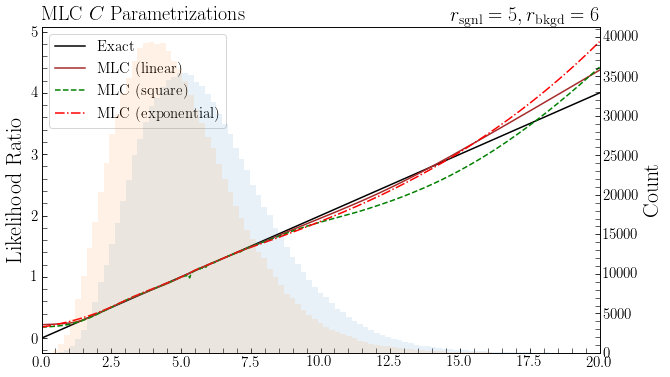

In [15]:
lr_plot([lr_1, lr_2, lr_3], 
        r'MLC $C$ Parametrizations',
        filename='plots/mlc_c_param/set_{}/lrs.png'.format(num))

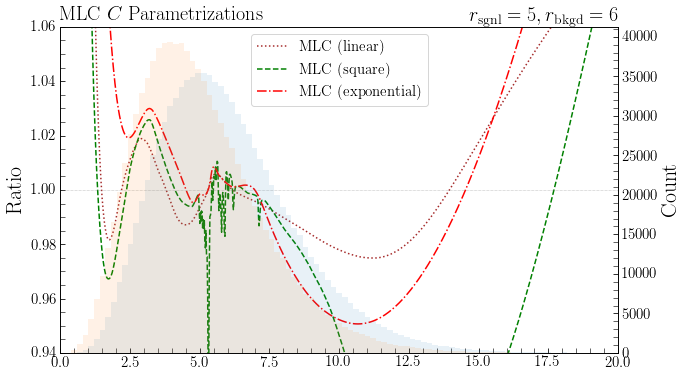

In [16]:
lrr_plot([lrr_1, lrr_2, lrr_3], 
         r'MLC $C$ Parametrizations',
         filename='plots/mlc_c_param/set_{}/lrrs.png'.format(num))

# SQR $C$ Parametrizations

In [17]:
### Generate the data.
N = 10**6
r = 5
lam = 1

# Background is Gamma(r, λ). Signal is Gamma(r + 1, λ)
bkgd = np.random.gamma(r, lam, N)
sgnl = np.random.gamma(r + 1, lam, N)
D = np.concatenate([bkgd, sgnl])
X = (D - np.mean(D)) / np.std(D)
y = np.concatenate([np.zeros(N), np.ones(N)])

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [18]:
def lr(x):
    #return np.exp(-10 + 11) * (10/11)**x
    #return np.exp(-(1/(2 * sigma**2)) * ( (x - mu)**2 - (x + mu)**2))
    r_1 = r
    r_2 = r + 1
    v_1 = lam
    v_2 = lam
    return v_2**r_2 * np.math.factorial(r_1 - 1) * x**(r_2 - r_1) * \
           np.exp(-(v_2 - v_1)*x) / (v_1**r_1 * np.math.factorial(r_2 - 1))

In [19]:
num = 4
reps = 100

# Model parameters
params_1 = {'loss':sqr, 'output':'relu'}
params_2 = {'loss':square_sqr, 'output':'linear'}
params_3 = {'loss':exp_sqr, 'output':'linear'}

filestr_1 = 'models/sqr_c_param/set_' + str(num) + '/linear/model_{}.h5'
filestr_2 = 'models/sqr_c_param/set_' + str(num) + '/square/model_{}.h5'
filestr_3 = 'models/sqr_c_param/set_' + str(num) + '/exp/model_{}.h5'

In [22]:
%%time
# Train and save models

for i in range(reps):
    print(i, end = ' ')
    model_1 = train(**params_1)
    model_2 = train(**params_2)
    model_3 = train(**params_3)
    print()
    model_1.save_weights(filestr_1.format(i))
    model_2.save_weights(filestr_2.format(i))
    model_3.save_weights(filestr_3.format(i))

0 0.9757168889045715 0.9795824885368347 0.9757412672042847 
1 0.9759453535079956 1.1191786527633667 0.9757379293441772 
2 0.9797337651252747 1.1798219680786133 0.9758560657501221 
3 0.9761350154876709 0.9845009446144104 0.9756596088409424 
4 0.9776108264923096 11.07643985748291 0.9758428931236267 
5 0.975757360458374 0.9785449504852295 0.9757687449455261 
6 0.9757046103477478 0.9761680960655212 0.9759781360626221 
7 0.9766141176223755 0.9839410185813904 0.9757803678512573 
8 0.9757776856422424 0.9757000207901001 0.9758175611495972 
9 0.9758398532867432 0.988779604434967 0.9757117033004761 
10 0.9768133759498596 1.005584478378296 0.9756378531455994 
11 0.9761362671852112 0.977376401424408 0.9756782650947571 
12 0.9757599234580994 5.069163799285889 0.9755889177322388 
13 0.9768022894859314 0.9767839908599854 0.9756873846054077 
14 0.9911940097808838 0.9852023720741272 0.9757843017578125 
15 0.9762362241744995 0.9924392104148865 0.9757328629493713 
16 0.9755674600601196 1.0473099946975708

In [23]:
# Get model likelihood ratios.
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps
for i in range(reps):
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = pure_lr(model_1)
    lrs_2[i] = square_lr(model_2)
    lrs_3[i] = exp_lr(model_3)

In [24]:
# Get average predictions and errors. Add on the labels for plotting.
ds = np.linspace(0, 20, 1000)
xs = (ds - np.mean(D)) / np.std(D)

lr_1 = avg_lr(get_preds(lrs_1, xs)) + ('SQR (linear)',)
lr_2 = avg_lr(get_preds(lrs_2, xs)) + ('SQR (square)',)
lr_3 = avg_lr(get_preds(lrs_3, xs)) + ('SQR (exponential)',)

lrr_1 = avg_lrr(get_preds(lrs_1, xs), ds) + ('SQR (linear)',)
lrr_2 = avg_lrr(get_preds(lrs_2, xs), ds) + ('SQR (square)',)
lrr_3 = avg_lrr(get_preds(lrs_3, xs), ds) + ('SQR (exponential)',)

/tmp/ipykernel_27315/82558973.py:18: RuntimeWarning: divide by zero encountered in true_divide
  lrr_preds = preds / lr(xs)
/global/home/users/shahzar/anaconda3/envs/omnifold/lib/python3.8/site-packages/numpy/core/_methods.py:229: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


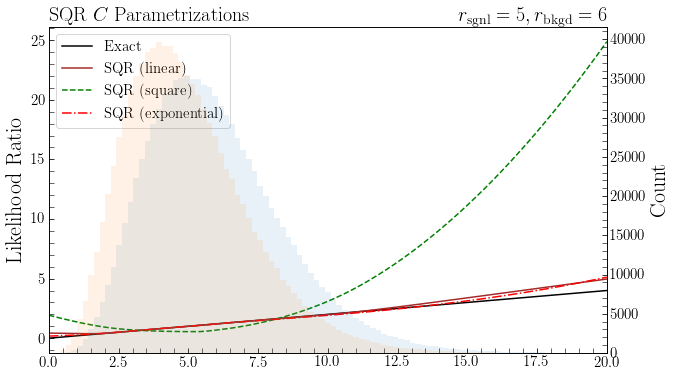

In [25]:
lr_plot([lr_1, lr_2, lr_3], 
        title=r'SQR $C$ Parametrizations',
        filename='plots/sqr_c_param/set_{}/lrs.png'.format(num))

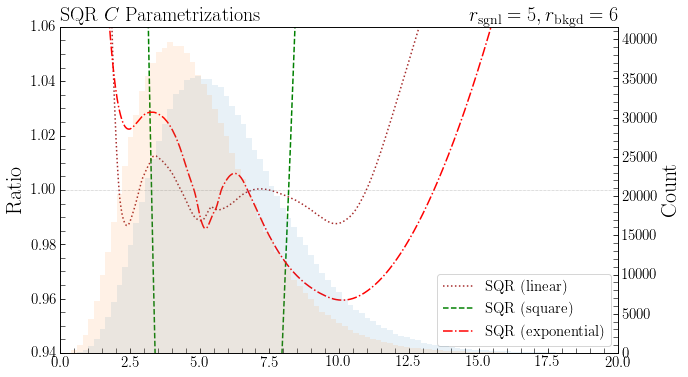

In [26]:
lrr_plot([lrr_1, lrr_2, lrr_3], 
         title=r'SQR $C$ Parametrizations',
         filename='plots/sqr_c_param/set_{}/lrrs.png'.format(num))

# SQR $A$/$B$ Parametrizations

In [ ]:
num = 3
reps = 20

ps = np.round(np.linspace(-2, 2, 81), 2)
sqr_filestr = 'models/sqr_ab_param/set_' + str(num) + '/linear/model_{}_{}.h5'
exp_filestr = 'models/sqr_ab_param/set_' + str(num) + '/exp/model_{}_{}.h5'

In [ ]:
# Train models
for p in ps:
    print('===================================================\n{}'.format(p))
    sqr_params = {'loss': get_sqr(p), 'output':'relu'}
    exp_params = {'loss': get_exp_sqr(p), 'output':'linear'}
    for i in range(reps):
        print(i, end = ' ')
        sqr_model = train(**sqr_params)
        exp_model = train(**exp_params)
        print()
        sqr_model.save_weights(sqr_filestr.format(p, i))
        exp_model.save_weights(exp_filestr.format(p, i))

In [ ]:
# Get model likelihood ratios.
sqr_lrs = {}
exp_lrs = {}
for p in ps:
    print(p)
    sqr_lrs[p] = [None] * reps
    exp_lrs[p] = [None] * reps
    sqr_params = {'loss': get_sqr(p), 'output':'relu'}
    exp_params = {'loss': get_exp_sqr(p), 'output':'linear'}
    for i in range(reps):
        sqr_model = create_model(**sqr_params)
        exp_model = create_model(**exp_params)
        sqr_model.load_weights(sqr_filestr.format(p, i))
        exp_model.load_weights(exp_filestr.format(p, i))
        sqr_lrs[p][i] = pow_lr(sqr_model, p)
        exp_lrs[p][i] = exp_pow_lr(exp_model, p)
        print(i, end = ' ')
    print()

In [ ]:
sqr_mae_avg = []
sqr_mae_err = []
exp_mae_avg = []
exp_mae_err = []

for p in ps:
    sqr_maes = [mae(lr) for lr in sqr_lrs[p]]
    exp_maes = [mae(lr) for lr in exp_lrs[p]]
    sqr_mae_avg += [np.mean(sqr_maes)]
    sqr_mae_err += [np.std(sqr_maes)]
    exp_mae_avg += [np.mean(exp_maes)]
    exp_mae_err += [np.std(exp_maes)]
    print(p, '\t', sqr_mae_avg[-1], '\t', exp_mae_avg[-1])
    print(p, '\t', sqr_mae_avg[-1])

In [ ]:
sqr_mae_avg = np.array(sqr_mae_avg)
sqr_mae_err = np.array(sqr_mae_err)
exp_mae_avg = np.array(exp_mae_avg)
exp_mae_err = np.array(exp_mae_err)

In [ ]:
fig, ax = plt.subplots(figsize = (10, 6))

plt.plot(ps, sqr_mae_avg, c='blue', label='linear')
plt.plot(ps, exp_mae_avg, c='red', label='exponential')
plt.legend()

plt.minorticks_on()
plt.tick_params(direction='in', which='both',length=5)
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$p$')

plt.title(r"$\mu_{\rm{sgnl}}="+str(mu)+r", \mu_{\rm{bkgd}}="+str(-mu)+r"$",
          loc="right",
          fontsize=20);
plt.title(r"SQR $A/B$ Parametrization",loc="left",fontsize=20);
plt.savefig('plots/sqr_ab_param/set_{}/maes.png'.format(num), 
            dpi=1200, 
            bbox_inches='tight')

# Loss Comparisons

In [ ]:
num = 1
reps = 100
Ns = 10**np.arange(2, 8)

# Model parameters
bce_params = {'loss':bce}
mse_params = {'loss':mse}
mlc_params = {'loss':exp_mlc, 'output':'linear'}
sqr_params = {'loss':exp_sqr, 'output':'linear'}

bce_filestr = 'models/loss_comp/set_' + str(num) + '/bce/model_{}_{}.h5'
mse_filestr = 'models/loss_comp/set_' + str(num) + '/mse/model_{}_{}.h5'
mlc_filestr = 'models/loss_comp/set_' + str(num) + '/mlc/model_{}_{}.h5'
sqr_filestr = 'models/loss_comp/set_' + str(num) + '/sqr/model_{}_{}.h5'

In [ ]:
# Train models
%%time

for N in Ns:
    print('===================================================\n{}'.format(N))
    # Generate data
    bkgd = np.random.normal(-mu, sigma, N)
    sgnl = np.random.normal(mu, sigma, N)
    X = np.concatenate([bkgd, sgnl])
    y = np.concatenate([np.zeros(N), np.ones(N)])

    X_train, X_test, y_train, y_test = train_test_split(X, y)
    
    for i in range(reps):
        print(i, end = ' ')
        bce_model = train(**bce_params)
        mse_model = train(**mse_params)
        mlc_model = train(**mlc_params)
        sqr_model = train(**sqr_params)
        print()
        bce_model.save_weights(bce_filestr.format(N, i))
        mse_model.save_weights(mse_filestr.format(N, i))
        mlc_model.save_weights(mlc_filestr.format(N, i))
        sqr_model.save_weights(sqr_filestr.format(N, i))

## Mean Absolute Error

In [ ]:
# Calculate mean absolute errors
bce_mae_avg = []
mse_mae_avg = []
mlc_mae_avg = []
sqr_mae_avg = []

bce_mae_err = []
mse_mae_err = []
mlc_mae_err = []
sqr_mae_err = []

for N in Ns:
    print(N)
    bce_lrs = [None] * reps
    mse_lrs = [None] * reps
    mlc_lrs = [None] * reps
    sqr_lrs = [None] * reps
    for i in range(reps):
        bce_model = create_model(**bce_params)
        bce_model.load_weights(bce_filestr.format(N, i))
        bce_lrs[i] = odds_lr(bce_model)

        mse_model = create_model(**mse_params)
        mse_model.load_weights(mse_filestr.format(N, i))
        mse_lrs[i] = odds_lr(mse_model)

        mlc_model = create_model(**mlc_params)
        mlc_model.load_weights(mlc_filestr.format(N, i))
        mlc_lrs[i] = exp_lr(mlc_model)

        sqr_model = create_model(**sqr_params)
        sqr_model.load_weights(sqr_filestr.format(N, i))
        sqr_lrs[i] = exp_lr(sqr_model)
    
    bce_maes = [mae(lr) for lr in bce_lrs]
    mse_maes = [mae(lr) for lr in mse_lrs]
    mlc_maes = [mae(lr) for lr in mlc_lrs]
    sqr_maes = [mae(lr) for lr in sqr_lrs]
    
    bce_mae_avg += [np.mean(bce_maes)]
    bce_mae_err += [np.std(bce_maes)]
    
    mse_mae_avg += [np.mean(mse_maes)]
    mse_mae_err += [np.std(mse_maes)]
    
    mlc_mae_avg += [np.mean(mlc_maes)]
    mlc_mae_err += [np.std(mlc_maes)]
    
    sqr_mae_avg += [np.mean(sqr_maes)]
    sqr_mae_err += [np.std(sqr_maes)]

bce_mae_avg = np.array(bce_mae_avg)
mse_mae_avg = np.array(mse_mae_avg)
mlc_mae_avg = np.array(mlc_mae_avg)
sqr_mae_avg = np.array(sqr_mae_avg)

bce_mae_err = np.array(bce_mae_err)
mse_mae_err = np.array(mse_mae_err)
mlc_mae_err = np.array(mlc_mae_err)
sqr_mae_err = np.array(sqr_mae_err)

In [ ]:
fig, ax = plt.subplots(figsize = (10, 6))

plt.plot(Ns, bce_mae_avg, c='brown', ls=':', label='BCE')
plt.plot(Ns, mse_mae_avg, c='green', ls='--', label='MSE')
plt.plot(Ns, mlc_mae_avg, c='red', ls='--', label='MLC')
plt.plot(Ns, sqr_mae_avg, c='blue', ls='-.', label='SQR')
#plt.fill_between(Ns, bce_mae_avg - bce_mae_err, bce_mae_avg + bce_mae_err, color='brown', alpha=0.1)
#plt.fill_between(Ns, mse_mae_avg - mse_mae_err, mse_mae_avg + mse_mae_err, color='green', alpha=0.1)
#plt.fill_between(Ns, mlc_mae_avg - mlc_mae_err, mlc_mae_avg + mlc_mae_err, color='red', alpha=0.1)
#plt.fill_between(Ns, sqr_mae_avg - sqr_mae_err, sqr_mae_avg + sqr_mae_err, color='blue', alpha=0.1)
plt.legend()

plt.xscale("log", base=10)
plt.minorticks_on()
plt.tick_params(direction='in', which='both',length=5)
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$N$')

plt.title(r"$\mu_{\rm{sgnl}}="+str(mu)+r", \mu_{\rm{bkgd}}="+str(-mu)+r"$",
          loc="right",
          fontsize=20);
plt.savefig('plots/loss_comp/set_{}/maes.png'.format(num),
            dpi=1200, 
            bbox_inches='tight')

## Likelihood Ratios

In [ ]:
N = 10**6
reps = 100

In [ ]:
# Load in models.
bce_lrs = [None] * reps
mse_lrs = [None] * reps
mlc_lrs = [None] * reps
sqr_lrs = [None] * reps
for i in range(reps):
    bce_model = create_model(**bce_params)
    bce_model.load_weights(bce_filestr.format(N, i))
    bce_lrs[i] = odds_lr(bce_model)
    
    mse_model = create_model(**mse_params)
    mse_model.load_weights(mse_filestr.format(N, i))
    mse_lrs[i] = odds_lr(mse_model)
    
    mlc_model = create_model(**mlc_params)
    mlc_model.load_weights(mlc_filestr.format(N, i))
    mlc_lrs[i] = exp_lr(mlc_model)
    
    sqr_model = create_model(**sqr_params)
    sqr_model.load_weights(sqr_filestr.format(N, i))
    sqr_lrs[i] = exp_lr(sqr_model)

In [ ]:
bce_lr = avg_lr(get_preds(bce_lrs)) + ('BCE',)
mse_lr = avg_lr(get_preds(mse_lrs)) + ('MSE',)
mlc_lr = avg_lr(get_preds(mlc_lrs)) + ('MLC',)
sqr_lr = avg_lr(get_preds(sqr_lrs)) + ('SQR',)

bce_lrr = avg_lrr(get_preds(bce_lrs)) + ('BCE',)
mse_lrr = avg_lrr(get_preds(mse_lrs)) + ('MSE',)
mlc_lrr = avg_lrr(get_preds(mlc_lrs)) + ('MLC',)
sqr_lrr = avg_lrr(get_preds(sqr_lrs)) + ('SQR',)

In [ ]:
lr_plot([bce_lr, mse_lr, mlc_lr, sqr_lr], 
        filename='plots/loss_comp/set_{}/lrs.png'.format(num))

In [ ]:
lrr_plot([bce_lrr, mse_lrr, mlc_lrr, sqr_lrr], 
         filename='plots/loss_comp/set_{}/lrrs.png'.format(num))

In [ ]:
bce_mae = np.mean([mae(lr) for lr in bce_lrs])
mse_mae = np.mean([mae(lr) for lr in mse_lrs])
mlc_mae = np.mean([mae(lr) for lr in mlc_lrs])
sqr_mae = np.mean([mae(lr) for lr in sqr_lrs])

In [ ]:
print(bce_mae, mse_mae, mlc_mae, sqr_mae)

# Interpolation Test

In [ ]:
num = 5
N = 10**6
mus = np.round(np.linspace(0.1, 1.5, 15), 2)
sigma = 1

reps = 50

# Model parameters
bce_params = {'loss':bce, 'verbose':0}
mse_params = {'loss':mse, 'verbose':0}
mlc_params = {'loss':exp_mlc, 'output':'linear', 'verbose':0}
sqr_params = {'loss':exp_sqr, 'output':'linear', 'verbose':0}

bce_filestr = 'models/interp/set_' + str(num) + '/bce/model_{}_{}.h5'
mse_filestr = 'models/interp/set_' + str(num) + '/mse/model_{}_{}.h5'
mlc_filestr = 'models/interp/set_' + str(num) + '/mlc/model_{}_{}.h5'
sqr_filestr = 'models/interp/set_' + str(num) + '/sqr/model_{}_{}.h5'

In [ ]:
%%time

for mu in mus:
    print('===================================================\n{}'.format(mu))
    # Generate data
    bkgd = np.random.normal(-mu, sigma, N)
    sgnl = np.random.normal(mu, sigma, N)
    X = np.concatenate([bkgd, sgnl])
    y = np.concatenate([np.zeros(N), np.ones(N)])
    
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    
    for i in range(reps):
        print(i, end = ' ')
        bce_model = train(**bce_params)
        mse_model = train(**mse_params)
        mlc_model = train(**mlc_params)
        sqr_model = train(**sqr_params)
        print()
        bce_model.save_weights(bce_filestr.format(mu, i))
        mse_model.save_weights(mse_filestr.format(mu, i))
        mlc_model.save_weights(mlc_filestr.format(mu, i))
        sqr_model.save_weights(sqr_filestr.format(mu, i))

## Expected Error

In [ ]:
# Calculate mean absolute errors
bce_mae_avg = []
mse_mae_avg = []
mlc_mae_avg = []
sqr_mae_avg = []

bce_mae_err = []
mse_mae_err = []
mlc_mae_err = []
sqr_mae_err = []

bce_mpe_avg = []
mse_mpe_avg = []
mlc_mpe_avg = []
sqr_mpe_avg = []

bce_mpe_err = []
mse_mpe_err = []
mlc_mpe_err = []
sqr_mpe_err = []

for mu in mus:
    print(mu)
    bce_lrs = [None] * reps
    mse_lrs = [None] * reps
    mlc_lrs = [None] * reps
    sqr_lrs = [None] * reps
    for i in range(reps):
        bce_model = create_model(**bce_params)
        bce_model.load_weights(bce_filestr.format(mu, i))
        bce_lrs[i] = odds_lr(bce_model)

        mse_model = create_model(**mse_params)
        mse_model.load_weights(mse_filestr.format(mu, i))
        mse_lrs[i] = odds_lr(mse_model)

        mlc_model = create_model(**mlc_params)
        mlc_model.load_weights(mlc_filestr.format(mu, i))
        mlc_lrs[i] = exp_lr(mlc_model)

        sqr_model = create_model(**sqr_params)
        sqr_model.load_weights(sqr_filestr.format(mu, i))
        sqr_lrs[i] = exp_lr(sqr_model)
    
    mae = make_mae(mu, sigma)
    bce_maes = [mae(lr) for lr in bce_lrs]
    mse_maes = [mae(lr) for lr in mse_lrs]
    mlc_maes = [mae(lr) for lr in mlc_lrs]
    sqr_maes = [mae(lr) for lr in sqr_lrs]
    
    bce_mae_avg += [np.mean(bce_maes)]
    bce_mae_err += [np.std(bce_maes)]
    
    mse_mae_avg += [np.mean(mse_maes)]
    mse_mae_err += [np.std(mse_maes)]
    
    mlc_mae_avg += [np.mean(mlc_maes)]
    mlc_mae_err += [np.std(mlc_maes)]
    
    sqr_mae_avg += [np.mean(sqr_maes)]
    sqr_mae_err += [np.std(sqr_maes)]
    
    print(bce_mae_avg[-1], mse_mae_avg[-1], mlc_mae_avg[-1], sqr_mae_avg[-1])
    
    mpe = make_mpe(mu, sigma)
    bce_mpes = [mpe(lr) for lr in bce_lrs]
    mse_mpes = [mpe(lr) for lr in mse_lrs]
    mlc_mpes = [mpe(lr) for lr in mlc_lrs]
    sqr_mpes = [mpe(lr) for lr in sqr_lrs]
    
    bce_mpe_avg += [np.mean(bce_mpes)]
    bce_mpe_err += [np.std(bce_mpes)]
    
    mse_mpe_avg += [np.mean(mse_mpes)]
    mse_mpe_err += [np.std(mse_mpes)]
    
    mlc_mpe_avg += [np.mean(mlc_mpes)]
    mlc_mpe_err += [np.std(mlc_mpes)]
    
    sqr_mpe_avg += [np.mean(sqr_mpes)]
    sqr_mpe_err += [np.std(sqr_mpes)]
    
    print(bce_mpe_avg[-1], mse_mpe_avg[-1], mlc_mpe_avg[-1], sqr_mpe_avg[-1])

bce_mae_avg = np.array(bce_mae_avg)
mse_mae_avg = np.array(mse_mae_avg)
mlc_mae_avg = np.array(mlc_mae_avg)
sqr_mae_avg = np.array(sqr_mae_avg)

bce_mae_err = np.array(bce_mae_err)
mse_mae_err = np.array(mse_mae_err)
mlc_mae_err = np.array(mlc_mae_err)
sqr_mae_err = np.array(sqr_mae_err)

bce_mpe_avg = np.array(bce_mpe_avg)
mse_mpe_avg = np.array(mse_mpe_avg)
mlc_mpe_avg = np.array(mlc_mpe_avg)
sqr_mpe_avg = np.array(sqr_mpe_avg)

bce_mpe_err = np.array(bce_mpe_err)
mse_mpe_err = np.array(mse_mpe_err)
mlc_mpe_err = np.array(mlc_mpe_err)
sqr_mpe_err = np.array(sqr_mpe_err)

In [ ]:
fig, ax = plt.subplots(figsize = (10, 6))

plt.plot(mus, bce_mae_avg, c='brown', ls=':', label='BCE')
plt.plot(mus, mse_mae_avg, c='green', ls='--', label='MSE')
plt.plot(mus, mlc_mae_avg, c='red', ls='--', label='MLC')
plt.plot(mus, sqr_mae_avg, c='blue', ls='-.', label='SQR')
plt.legend()

plt.yscale("log", basey=10)
plt.minorticks_on()
plt.tick_params(direction='in', which='both',length=5)
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$\mu$')

plt.savefig('plots/interp/set_{}/maes.png'.format(num),
            dpi=1200, 
            bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(figsize = (10, 6))

plt.plot(mus, bce_mpe_avg, c='brown', ls=':', label='BCE')
plt.plot(mus, mse_mpe_avg, c='green', ls='--', label='MSE')
plt.plot(mus, mlc_mpe_avg, c='red', ls='--', label='MLC')
plt.plot(mus, sqr_mpe_avg, c='blue', ls='-.', label='SQR')
plt.legend()
#plt.ylim(0, 5)

#plt.xscale("log", base=10)
plt.minorticks_on()
plt.tick_params(direction='in', which='both',length=5)
plt.ylabel('Mean Percent Error (\%)')
plt.xlabel(r'$\mu$')

plt.savefig('plots/interp/set_{}/mpes.png'.format(num),
            dpi=1200, 
            bbox_inches='tight')

## Single Test

In [ ]:
xs = np.linspace(-4, 4, 1000)
bce_lr = avg_lr(get_preds(bce_lrs, xs)) + ('BCE',)
mse_lr = avg_lr(get_preds(mse_lrs, xs)) + ('MSE',)
mlc_lr = avg_lr(get_preds(mlc_lrs, xs)) + ('MLC',)
sqr_lr = avg_lr(get_preds(sqr_lrs, xs)) + ('SQR',)

bce_lrr = avg_lrr(get_preds(bce_lrs, xs), xs) + ('BCE',)
mse_lrr = avg_lrr(get_preds(mse_lrs, xs), xs) + ('MSE',)
mlc_lrr = avg_lrr(get_preds(mlc_lrs, xs), xs) + ('MLC',)
sqr_lrr = avg_lrr(get_preds(sqr_lrs, xs), xs) + ('SQR',)

In [ ]:
lr_plot([bce_lr, mse_lr, mlc_lr, sqr_lr], 
        xs=xs,
        filename='plots/interp/set_{}/lrs.png'.format(num))

In [ ]:
lrr_plot([bce_lrr, mse_lrr, mlc_lrr, sqr_lrr], 
         xs=xs,
         filename='plots/interp/set_{}/lrrs.png'.format(num))

# Scratch

## 1. Loss Comparison for Gamma Data

In [ ]:
### Generate the data.
N = 10**6
r = 5
lam = 1

# Background is Gamma(r, λ). Signal is Gamma(r + 1, λ)
bkgd = np.random.gamma(r, lam, N)
sgnl = np.random.gamma(r + 1, lam, N)
D = np.concatenate([bkgd, sgnl])
X = (D - np.mean(D)) / np.std(D)
y = np.concatenate([np.zeros(N), np.ones(N)])

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
def lr(x):
    #return np.exp(-10 + 11) * (10/11)**x
    #return np.exp(-(1/(2 * sigma**2)) * ( (x - mu)**2 - (x + mu)**2))
    r_1 = r
    r_2 = r + 1
    v_1 = lam
    v_2 = lam
    return v_2**r_2 * np.math.factorial(r_1 - 1) * x**(r_2 - r_1) * \
           np.exp(-(v_2 - v_1)*x) / (v_1**r_1 * np.math.factorial(r_2 - 1))

In [ ]:
num = 4
reps = 20

# Model parameters
bce_params = {'loss':bce}
mse_params = {'loss':mse}
mlc_params = {'loss':exp_mlc, 'output':'linear'}
sqr_params = {'loss':exp_sqr, 'output':'linear'}

bce_filestr = 'models/scratch/set_' + str(num) + '/bce/model_{}.h5'
mse_filestr = 'models/scratch/set_' + str(num) + '/mse/model_{}.h5'
mlc_filestr = 'models/scratch/set_' + str(num) + '/mlc/model_{}.h5'
sqr_filestr = 'models/scratch/set_' + str(num) + '/sqr/model_{}.h5'

In [ ]:
%%time

for i in range(reps):
    print(i, end = ' ')
    bce_model = train(**bce_params)
    mse_model = train(**mse_params)
    mlc_model = train(**mlc_params)
    sqr_model = train(**sqr_params)
    print()
    bce_model.save_weights(bce_filestr.format(i))
    mse_model.save_weights(mse_filestr.format(i))
    mlc_model.save_weights(mlc_filestr.format(i))
    sqr_model.save_weights(sqr_filestr.format(i))

In [ ]:
# Load in models.
bce_lrs = [None] * reps
mse_lrs = [None] * reps
mlc_lrs = [None] * reps
sqr_lrs = [None] * reps
for i in range(reps):
    bce_model = create_model(**bce_params)
    bce_model.load_weights(bce_filestr.format(i))
    bce_lrs[i] = odds_lr(bce_model)
    
    mse_model = create_model(**mse_params)
    mse_model.load_weights(mse_filestr.format(i))
    mse_lrs[i] = odds_lr(mse_model)
    
    mlc_model = create_model(**mlc_params)
    mlc_model.load_weights(mlc_filestr.format(i))
    mlc_lrs[i] = exp_lr(mlc_model)
    
    sqr_model = create_model(**sqr_params)
    sqr_model.load_weights(sqr_filestr.format(i))
    sqr_lrs[i] = exp_lr(sqr_model)

In [ ]:
ds = np.linspace(0, 20, 1000)
xs = (ds - np.mean(D)) / np.std(D)

bce_lr = avg_lr(get_preds(bce_lrs, xs)) + ('BCE',)
mse_lr = avg_lr(get_preds(mse_lrs, xs)) + ('MSE',)
mlc_lr = avg_lr(get_preds(mlc_lrs, xs)) + ('MLC',)
sqr_lr = avg_lr(get_preds(sqr_lrs, xs)) + ('SQR',)

bce_lrr = avg_lrr(get_preds(bce_lrs, xs), ds) + ('BCE',)
mse_lrr = avg_lrr(get_preds(mse_lrs, xs), ds) + ('MSE',)
mlc_lrr = avg_lrr(get_preds(mlc_lrs, xs), ds) + ('MLC',)
sqr_lrr = avg_lrr(get_preds(sqr_lrs, xs), ds) + ('SQR',)

In [ ]:
lr_plot([bce_lr, mse_lr, mlc_lr, sqr_lr], 
        filename='plots/scratch/set_{}/lrs.png'.format(num))

In [ ]:
lrr_plot([bce_lrr, mse_lrr, mlc_lrr, sqr_lrr], 
         filename='plots/scratch/set_{}/lrrs.png'.format(num))

## 2. Test on Non-Zero-Centered Gaussians

In [ ]:
N = 10**6
mu = 10
d = 0.1
sigma = 1

# Background is Normal(μ - d, σ). Signal is Normal(μ + d, σ))
bkgd = np.random.normal(mu - d, sigma, N)
sgnl = np.random.normal(mu + d, sigma, N)
D = np.concatenate([bkgd, sgnl])
X = (D - np.mean(D)) / np.std(D)
y = np.concatenate([np.zeros(N), np.ones(N)])

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
def lr(x):
    return np.exp(-(1/(2 * sigma**2)) * ( (x - 10.1)**2 - (x - 9.9)**2))

In [ ]:
num = 3
reps = 20

# Model parameters
bce_params = {'loss':bce}
mse_params = {'loss':mse}
mlc_params = {'loss':exp_mlc, 'output':'linear'}
sqr_params = {'loss':exp_sqr, 'output':'linear'}

bce_filestr = 'models/scratch/set_' + str(num) + '/bce/model_{}.h5'
mse_filestr = 'models/scratch/set_' + str(num) + '/mse/model_{}.h5'
mlc_filestr = 'models/scratch/set_' + str(num) + '/mlc/model_{}.h5'
sqr_filestr = 'models/scratch/set_' + str(num) + '/sqr/model_{}.h5'

In [ ]:
%%time

for i in range(reps):
    print(i, end = ' ')
    bce_model = train(**bce_params)
    mse_model = train(**mse_params)
    mlc_model = train(**mlc_params)
    sqr_model = train(**sqr_params)
    print()
    bce_model.save_weights(bce_filestr.format(i))
    mse_model.save_weights(mse_filestr.format(i))
    mlc_model.save_weights(mlc_filestr.format(i))
    sqr_model.save_weights(sqr_filestr.format(i))

In [ ]:
# Load in models.
bce_lrs = [None] * reps
mse_lrs = [None] * reps
mlc_lrs = [None] * reps
sqr_lrs = [None] * reps
for i in range(reps):
    bce_model = create_model(**bce_params)
    bce_model.load_weights(bce_filestr.format(i))
    bce_lrs[i] = odds_lr(bce_model)
    
    mse_model = create_model(**mse_params)
    mse_model.load_weights(mse_filestr.format(i))
    mse_lrs[i] = odds_lr(mse_model)
    
    mlc_model = create_model(**mlc_params)
    mlc_model.load_weights(mlc_filestr.format(i))
    mlc_lrs[i] = exp_lr(mlc_model)
    
    sqr_model = create_model(**sqr_params)
    sqr_model.load_weights(sqr_filestr.format(i))
    sqr_lrs[i] = exp_lr(sqr_model)

In [ ]:
ds = np.linspace(4, 16, 1000)
xs = (ds - np.mean(D)) / np.std(D)

bce_lr = avg_lr(get_preds(bce_lrs, xs)) + ('BCE',)
mse_lr = avg_lr(get_preds(mse_lrs, xs)) + ('MSE',)
mlc_lr = avg_lr(get_preds(mlc_lrs, xs)) + ('MLC',)
sqr_lr = avg_lr(get_preds(sqr_lrs, xs)) + ('SQR',)

bce_lrr = avg_lrr(get_preds(bce_lrs, xs), ds) + ('BCE',)
mse_lrr = avg_lrr(get_preds(mse_lrs, xs), ds) + ('MSE',)
mlc_lrr = avg_lrr(get_preds(mlc_lrs, xs), ds) + ('MLC',)
sqr_lrr = avg_lrr(get_preds(sqr_lrs, xs), ds) + ('SQR',)

In [ ]:
lr_plot([bce_lr, mse_lr, mlc_lr, sqr_lr], 
        filename='plots/scratch/set_{}/lrs.png'.format(num))

In [ ]:
lrr_plot([bce_lrr, mse_lrr, mlc_lrr, sqr_lrr], 
         filename='plots/scratch/set_{}/lrrs.png'.format(num))